# Preamble

In [1]:
using Plots, SymPy, DifferentialEquations, Interpolations

In [2]:
Mpl = 2.435e18; # reduced Planck mass in GeV
c = 299792458; # speed of light in m/s
KinGeV = (1.160e4)^-1 * 10^-9; # Kelvin in GeV
Mpcinm = 3.086e16 * 10^6; # Mpc in m
GeVinminv = 10^9/(1.973e-7); # GeV in m^-1
GeVinMpcinv = GeVinminv * Mpcinm; # GeV in Mpc^-1
MpcinvinHz = c/Mpcinm; # Mpc^inv in Hz
yrins = 365.2422 * 24 * 60 * 60; # yr in s

Or0h2 = 4.2e-5; # current radiation density parameter * h^2
Hubblh = 0.674; # normalised Hubble parameter h

# Background

## calculation

In [3]:
ai = [1, 1.11724, 3.12672e-1, -4.68049e-2, -2.65004e-2, -1.19760e-3, 1.82812e-4, 1.36436e-4, 8.55051e-5, 1.22840e-5, 3.82259e-7, -6.87035e-9];
bi = [1.43382e-2, 1.37559e-2, 2.92108e-3, -5.38533e-4, -1.62496e-4, -2.87906e-5, -3.84278e-6, 2.78776e-6, 7.40342e-7, 1.17210e-7, 3.72499e-9, -6.74107e-11];
ci = [1, 6.07869e-1, -1.54485e-1, -2.24034e-1, -2.82147e-2, 2.90620e-2, 6.86778e-3, -1.00005e-3, -1.69104e-4, 1.06301e-5, 1.69528e-6, -9.33311e-8];
di = [7.07388e1, 9.18011e1, 3.31892e1, -1.39779, -1.52558, -1.97857e-2, -1.60146e-1, 8.22615e-5, 2.02651e-2, -1.82134e-5, 7.83943e-5, 7.13518e-5];

In [4]:
Tth = 0.12; # temperature separation in GeV

In [5]:
grhohigh(T) = sum([ai[i]*log(T)^(i - 1) for i=1:12]) / sum([bi[i]*log(T)^(i - 1) for i=1:12]); # eff. DoF for energy density for T > 0.12 GeV
gshigh(T) = grhohigh(T) / (1 + sum([ci[i]*log(T)^(i - 1) for i=1:12]) / sum([di[i]*log(T)^(i - 1) for i=1:12])); # eff. DoF for entropy for T > 0.12 GeV

In [6]:
rhohigh(T) = π^2/30*grhohigh(T)*T^4; # energy density for T > 0.12 GeV
shigh(T) = 2*π^2/45*gshigh(T)*T^3; # entropy for T > 0.12 GeV
phigh(T) = T*shigh(T) - rhohigh(T); # pressure for T > 0.12 GeV

In [7]:
# some fitting functions
Sfit(x) = 1 + 7/4*exp(-1.0419*x) * (1 + 1.034*x + 0.456426*x^2 + 0.0595249*x^3);
frho(x) = exp(-1.04855*x) * (1 + 1.03757*x + 0.508630*x^2 + 0.0893988*x^3);
brho(x) = exp(-1.03149*x) * (1 + 1.03317*x + 0.398264*x^2 + 0.0648056*x^3);
fs(x) = exp(-1.04190*x) * (1 + 1.03400*x + 0.456426*x^2 + 0.0595248*x^3);
bs(x) = exp(-1.03365*x) * (1 + 1.03397*x + 0.342548*x^2 + 0.0506182*x^3);

In [8]:
# mass params. in GeV
me = 511e-6;
mmu = 0.1056;
mpi0 = 0.13;
mpipm = 0.140;
m1 = 0.5;
m2 = 0.77;
m3 = 1.2;
m4 = 2;

In [9]:
# neutrino temperature
Tnu(T) = (4/11)^(1/3) * Sfit(me/T)^(1/3) * T;

In [10]:
grhogammalow(T) = 2.030 + 3.495*frho(me/T) + 3.446*frho(mmu/T) + 1.05*brho(mpi0/T) + 2.08*brho(mpipm/T) + 4.165*brho(m1/T) + 30.55*brho(m2/T) + 89.4*brho(m3/T) + 8209*brho(m4/T); # eff. DoF for photon energy density for T < 0.12 GeV
gsgammalow(T) = 2.008 + 3.442*fs(me/T) + 3.468*fs(mmu/T) + 1.034*bs(mpi0/T) + 2.068*bs(mpipm/T) + 4.16*bs(m1/T) + 30.55*bs(m2/T) + 90*bs(m3/T) + 6209*bs(m4/T); # eff. DoF for photon entropy for T < 0.12 GeV
grhonulow(T) = 1.353*Sfit(me/T)^(4/3); # eff. DoF for neutrino energy density for T < 0.12 GeV
gsnulow(T) = 1.923*Sfit(me/T); # eff. DoF for neutrino entropy for T < 0.12 GeV

In [11]:
# T < 0.12 GeV
rhogammalow(T) = π^2/30*grhogammalow(T)*T^4; # photon energy density
sgammalow(T) = 2*π^2/45*gsgammalow(T)*T^3; # photon entropy
rhonulow(T) = π^2/30*grhonulow(T)*T^4; # neutrino energy density
snulow(T) = 2*π^2/45*gsnulow(T)*T^3; # neutrino entropy
pgammalow(T) = T*sgammalow(T) - rhogammalow(T); # photon pressure
pnulow(T) = Tnu(T)*snulow(T) - rhonulow(T); # neutrino pressure
rholow(T) = rhogammalow(T) + rhonulow(T); # total energy density
plow(T) = pgammalow(T) + pnulow(T); # total pressure

In [12]:
function grho(T) # eff. DoF for energy density
    if T >= Tth
        return grhohigh(T)
    else
        return grhogammalow(T) + grhonulow(T)
    end
end;

function grhop(T) # T-derivative of grho
    Tp = symbols("Tp")
    if T >= Tth
        return diff(grhohigh(Tp)).subs(Tp,T)
    else
        return diff(grhogammalow(Tp) + grhonulow(Tp)).subs(Tp,T) 
    end
end;

function gs(T) # eff. DoF for entropy
    if T >= Tth
        return gshigh(T)
    else
        return gsgammalow(T) + gsnulow(T)
    end
end;

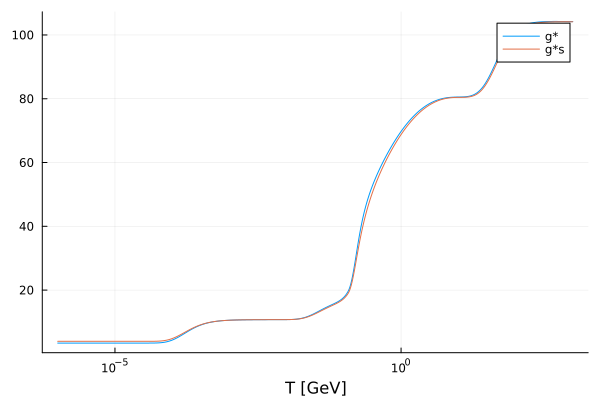

In [13]:
Tlist = [10^i for i=-6:0.01:3]
plot(grho, Tlist, xscale=:log10, label="g*", xlabel="T [GeV]")
plot!(gs, Tlist, label="g*s")

In [14]:
function rho(T) # energy density
    if T >= Tth
        return rhohigh(T)
    else 
        return rholow(T)
    end
end;

function press(T) # pressure
    if T >= Tth
        return phigh(T)
    else
        return plow(T)
    end
end;

In [15]:
EoSw(T) = press(T)/rho(T); # equation-of-state param. w

function cs2(T) # sound speed squared
    Tp = symbols("Tp")
    if T >= Tth
        return (diff(phigh(Tp))/diff(rhohigh(Tp))).subs(Tp,T)
    else
        return (diff(plow(Tp))/diff(rholow(Tp))).subs(Tp,T)
    end
end;

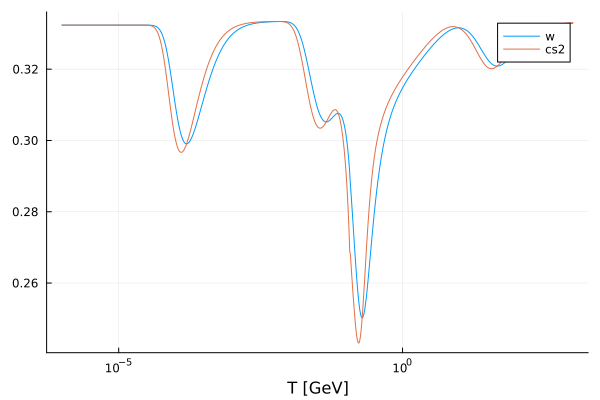

In [16]:
plot(EoSw, Tlist, xscale=:log10, label="w", xlabel="T [GeV]")
plot!(cs2, Tlist, label="cs2")

In [17]:
T0 = 2.725*KinGeV; # current temperature
grho0 = grho(T0); # current grho
gs0 = gs(T0); # current gs

In [18]:
calH(T, scalea) = scalea * sqrt(rho(T)/3/Mpl^2) * GeVinMpcinv; # conformal Hubble in Mpc^-1

In [19]:
Ti = 1e6; # initial temperature
scaleai = (gs0/gs(Ti))^(1/3)*T0/Ti; # temporal initial scale factor 
etai = 1/calH(Ti, scaleai); # initial conformal time

etaf = 10; # final conformal time

In [27]:
function bgEoM(du,u,p,lneta) # u[1] = T, u[2] = scalea
    du[1] = -3*exp(lneta)*(1 + EoSw(u[1])) * calH(u[1], u[2]) * grho(u[1]) / (grhop(u[1]) + 4*grho(u[1])/u[1])
    du[2] = exp(lneta)*u[2]*calH(u[1],u[2])
end;

ui = [Ti,scaleai];
lnetaspan = (log(etai),log(etaf));
bgprob = ODEProblem(bgEoM,ui,lnetaspan);
@time bgsol = solve(bgprob,Tsit5(),reltol=1e-10,abstol=1e-10);

 49.677090 seconds (12.72 M allocations: 411.293 MiB, 0.21% gc time, 0.02% compilation time: 100% of which was recompilation)


In [28]:
Tsol(eta) = bgsol(log(eta))[1];
asol(eta) = bgsol(log(eta))[2];

In [29]:
norm = Tsol(etaf)/T0*asol(etaf); # renormalisation factor so that a0 = 1
anorm(eta) = asol(eta/norm)/norm; # renormalised scale factor
Tnorm(eta) = Tsol(eta/norm); # T with the renormalised eta
calHnorm(eta) = calH(Tnorm(eta), anorm(eta)); # calH with the renormalised eta
af = anorm(norm*etaf); # renormalised scale factor at the final time
calHf = calHnorm(norm*etaf); # calH at the final time

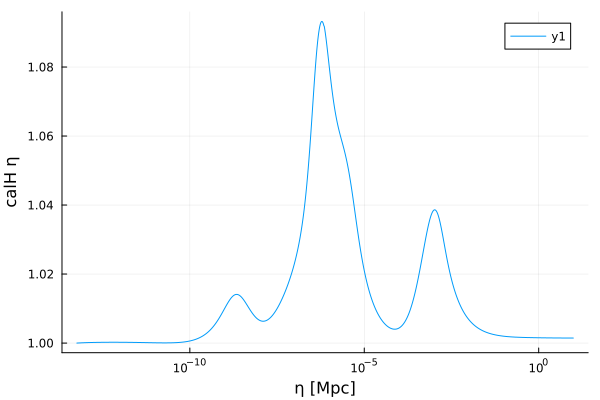

In [30]:
etalist = [10^i for i=log10(norm*etai):0.01:log10(norm*etaf)];
plot(etalist, map(x -> x*calHnorm(x), etalist), xscale=:log10, xlabel="η [Mpc]", ylabel="calH η")

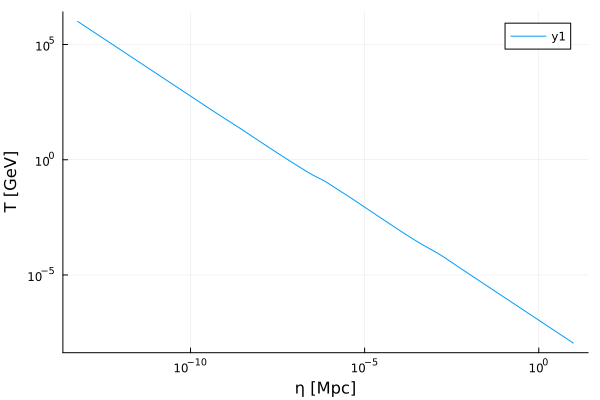

In [26]:
plot(Tnorm, etalist, xscale=:log10, yscale=:log10, xlabel="η [Mpc]", ylabel="T [GeV]")

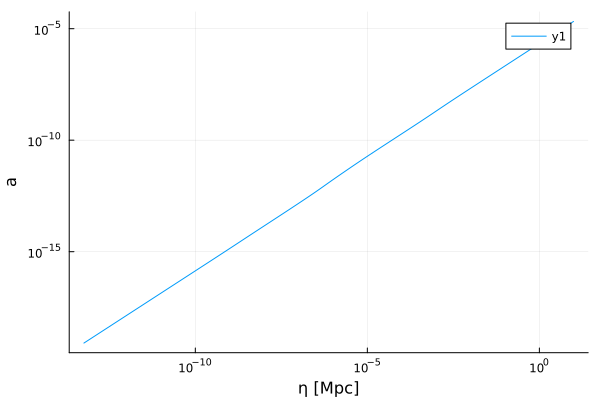

In [27]:
plot(anorm, etalist, xscale=:log10, yscale=:log10, xlabel="η [Mpc]", ylabel="a")

In [28]:
EoSwsol(eta) = EoSw(Tnorm(eta));
cs2sol(eta) = cs2(Tnorm(eta));
grhosol(eta) = grho(Tnorm(eta));
gssol(eta) = gs(Tnorm(eta));

In [78]:
lnetaspan = log10(norm*etai):0.01:log10(norm*etaf)

lnetaList = [lneta for lneta in lnetaspan];
anormList = [anorm(10^lneta) for lneta in lnetaspan];
calHList = [calHnorm(10^lneta) for lneta in lnetaspan];
EoSwList = [EoSwsol(10^lneta) for lneta in lnetaspan];
cs2List = [cs2sol(10^lneta) for lneta in lnetaspan];
grhoList = [grhosol(10^lneta) for lneta in lnetaspan];
gsList = [gssol(10^lneta) for lneta in lnetaspan];

In [80]:
open("bg.dat","w") do out
    Base.print_array(out, hcat(lnetaList[:],anormList[:],calHList[:],EoSwList[:],cs2List[:],grhoList[:],gsList[:]))
end

## load

In [4]:
f = open("bg.dat","r");
body = readlines(f);
close(f)

strarray = [split(body[i],r"\s+",keepempty=false) for i=1:length(body)];
numarray = [parse.(Float64, strarray[i]) for i=1:length(strarray)];

lnetaList = [numarray[i][1] for i=1:length(numarray)];
anormList = [numarray[i][2] for i=1:length(numarray)];
calHList = [numarray[i][3] for i=1:length(numarray)];
EoSwList = [numarray[i][4] for i=1:length(numarray)];
cs2List = [numarray[i][5] for i=1:length(numarray)];
grhoList = [numarray[i][6] for i=1:length(numarray)];
gsList = [numarray[i][7] for i=1:length(numarray)];

In [5]:
lnetaspan = range(lnetaList[1], lnetaList[length(lnetaList)], length=length(lnetaList))

aCSI = CubicSplineInterpolation(lnetaspan, anormList);
aint(eta) = aCSI(log10(eta));

calHCSI = CubicSplineInterpolation(lnetaspan, calHList);
calHint(eta) = calHCSI(log10(eta));

EoSwCSI = CubicSplineInterpolation(lnetaspan, EoSwList);
EoSwint(eta) = EoSwCSI(log10(eta));

cs2CSI = CubicSplineInterpolation(lnetaspan, cs2List);
cs2int(eta) = cs2CSI(log10(eta));

grhoCSI = CubicSplineInterpolation(lnetaspan, grhoList);
grhoint(eta) = grhoCSI(log10(eta));

gsCSI = CubicSplineInterpolation(lnetaspan, gsList);
gsint(eta) = gsCSI(log10(eta));

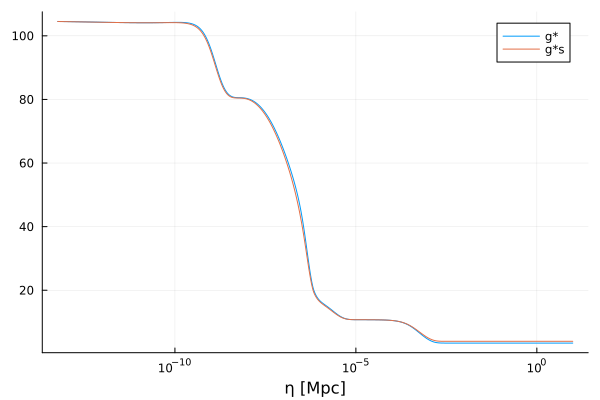

In [6]:
etaList = [10^lnetaList[i] for i=1:length(lnetaList)];
plot(grhoint, etaList, xscale=:log10, label="g*", xlabel="η [Mpc]")
plot!(gsint, etaList, label="g*s")

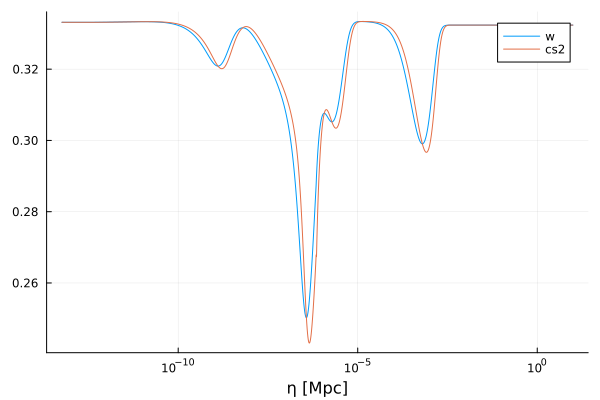

In [7]:
plot(EoSwint, etaList, xscale=:log10, label="w", xlabel="η [Mpc]")
plot!(cs2int, etaList, label="cs2")

# Scalar

In [42]:
kmin = 1e5;
kmax = 1e8;
kList = [10^lnk for lnk=log10(kmin):0.01:log10(kmax)];

etai = 1e-13;
etaf = 5;
etaList = [10^lneta for lneta=log10(etai):0.01:log10(etaf)];

In [43]:
function scalarEoM(du,u,p,eta) # u[1] = Phi, u[2] = dPhideta, p[1] = k
    du[1] = u[2]
    du[2] = - 3*calHint(eta)*(1 + cs2int(eta))*u[2] - (cs2int(eta)*p[1]^2 + 3*calHint(eta)^2*(cs2int(eta) - EoSwint(eta)))*u[1]
end;

ui = [1,0];
etaspan = (etai,etaf);

function scalarList()
    scalarList = []
    Threads.@threads for i=1:length(kList)
        p = [kList[i]]
        scalarprob = ODEProblem(scalarEoM,ui,etaspan,p)
        scalarsol = solve(scalarprob,Rosenbrock23())
        Phisol(eta) = scalarsol(eta)[1]
        Pisol(eta) = scalarsol(eta)[2]
        #scalarList[i] = [Phisol,Pisol]
        push!(scalarList, [p[1],Phisol,Pisol])
    end
    sort!(scalarList, by =x -> x[1])
    return scalarList
end;

In [44]:
@time scalarsol = scalarList();

296.234845 seconds (4.55 G allocations: 96.669 GiB, 59.46% gc time, 0.11% compilation time: 8% of which was recompilation)


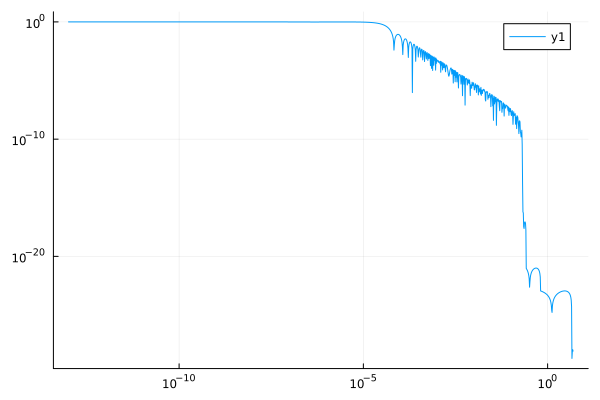

In [45]:
plot(etaList, [abs(scalarsol[7][2](etaList[i])) for i=1:length(etaList)], xscale=:log10, yscale=:log10)

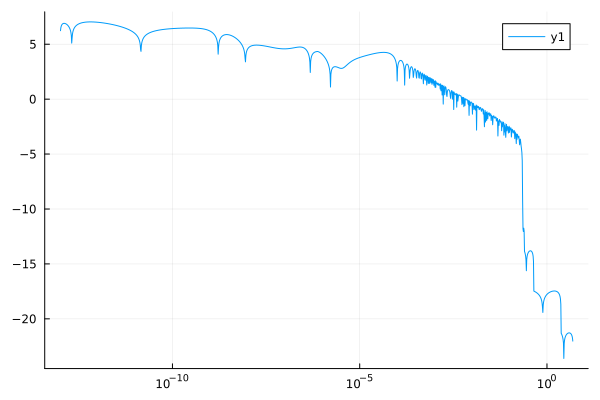

In [46]:
plot(etaList, [log10(abs(scalarsol[1][3](etaList[i]))) for i=1:length(etaList)], xscale=:log10)

In [47]:
open("Phi.dat","w") do out
    Base.print_array(out, [scalarsol[j][2](etaList[i]) for i=1:length(etaList), j=1:length(kList)])
end;

open("Pi.dat","w") do out
    Base.print_array(out, [scalarsol[j][3](etaList[i]) for i=1:length(etaList), j=1:length(kList)])
end;